<a href="https://colab.research.google.com/github/hiiamjay/Deep-Learning/blob/main/Experiments/Exp-9/DL_EXP_9_Food_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from IPython.display import display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

## Get The Dataset

https://drive.google.com/drive/folders/1zf9iza_kdlhdZxBQ1OIKesbgy7rD23CH?usp=sharing

In [ ]:
%cd /content/drive/MyDrive/Deep Learning/food11

## Loading The Data And Visualization

In [ ]:
train = []
valid = []
test = []

for i in os.listdir('./training'):
  train_class = os.listdir(os.path.join('training',i))
  train.extend(train_class)
  valid_class = os.listdir(os.path.join('validation',i))
  valid.extend(valid_class)
  test_class = os.listdir(os.path.join('evaluation',i))
  test.extend(test_class)

print('Number of train images : {} \nNumber of validation images : {} \nNumber of test images : {}'.format(len(train),len(valid),len(test)))

Number of train images : 9866 
Number of validation images : 3430 
Number of test images : 3347


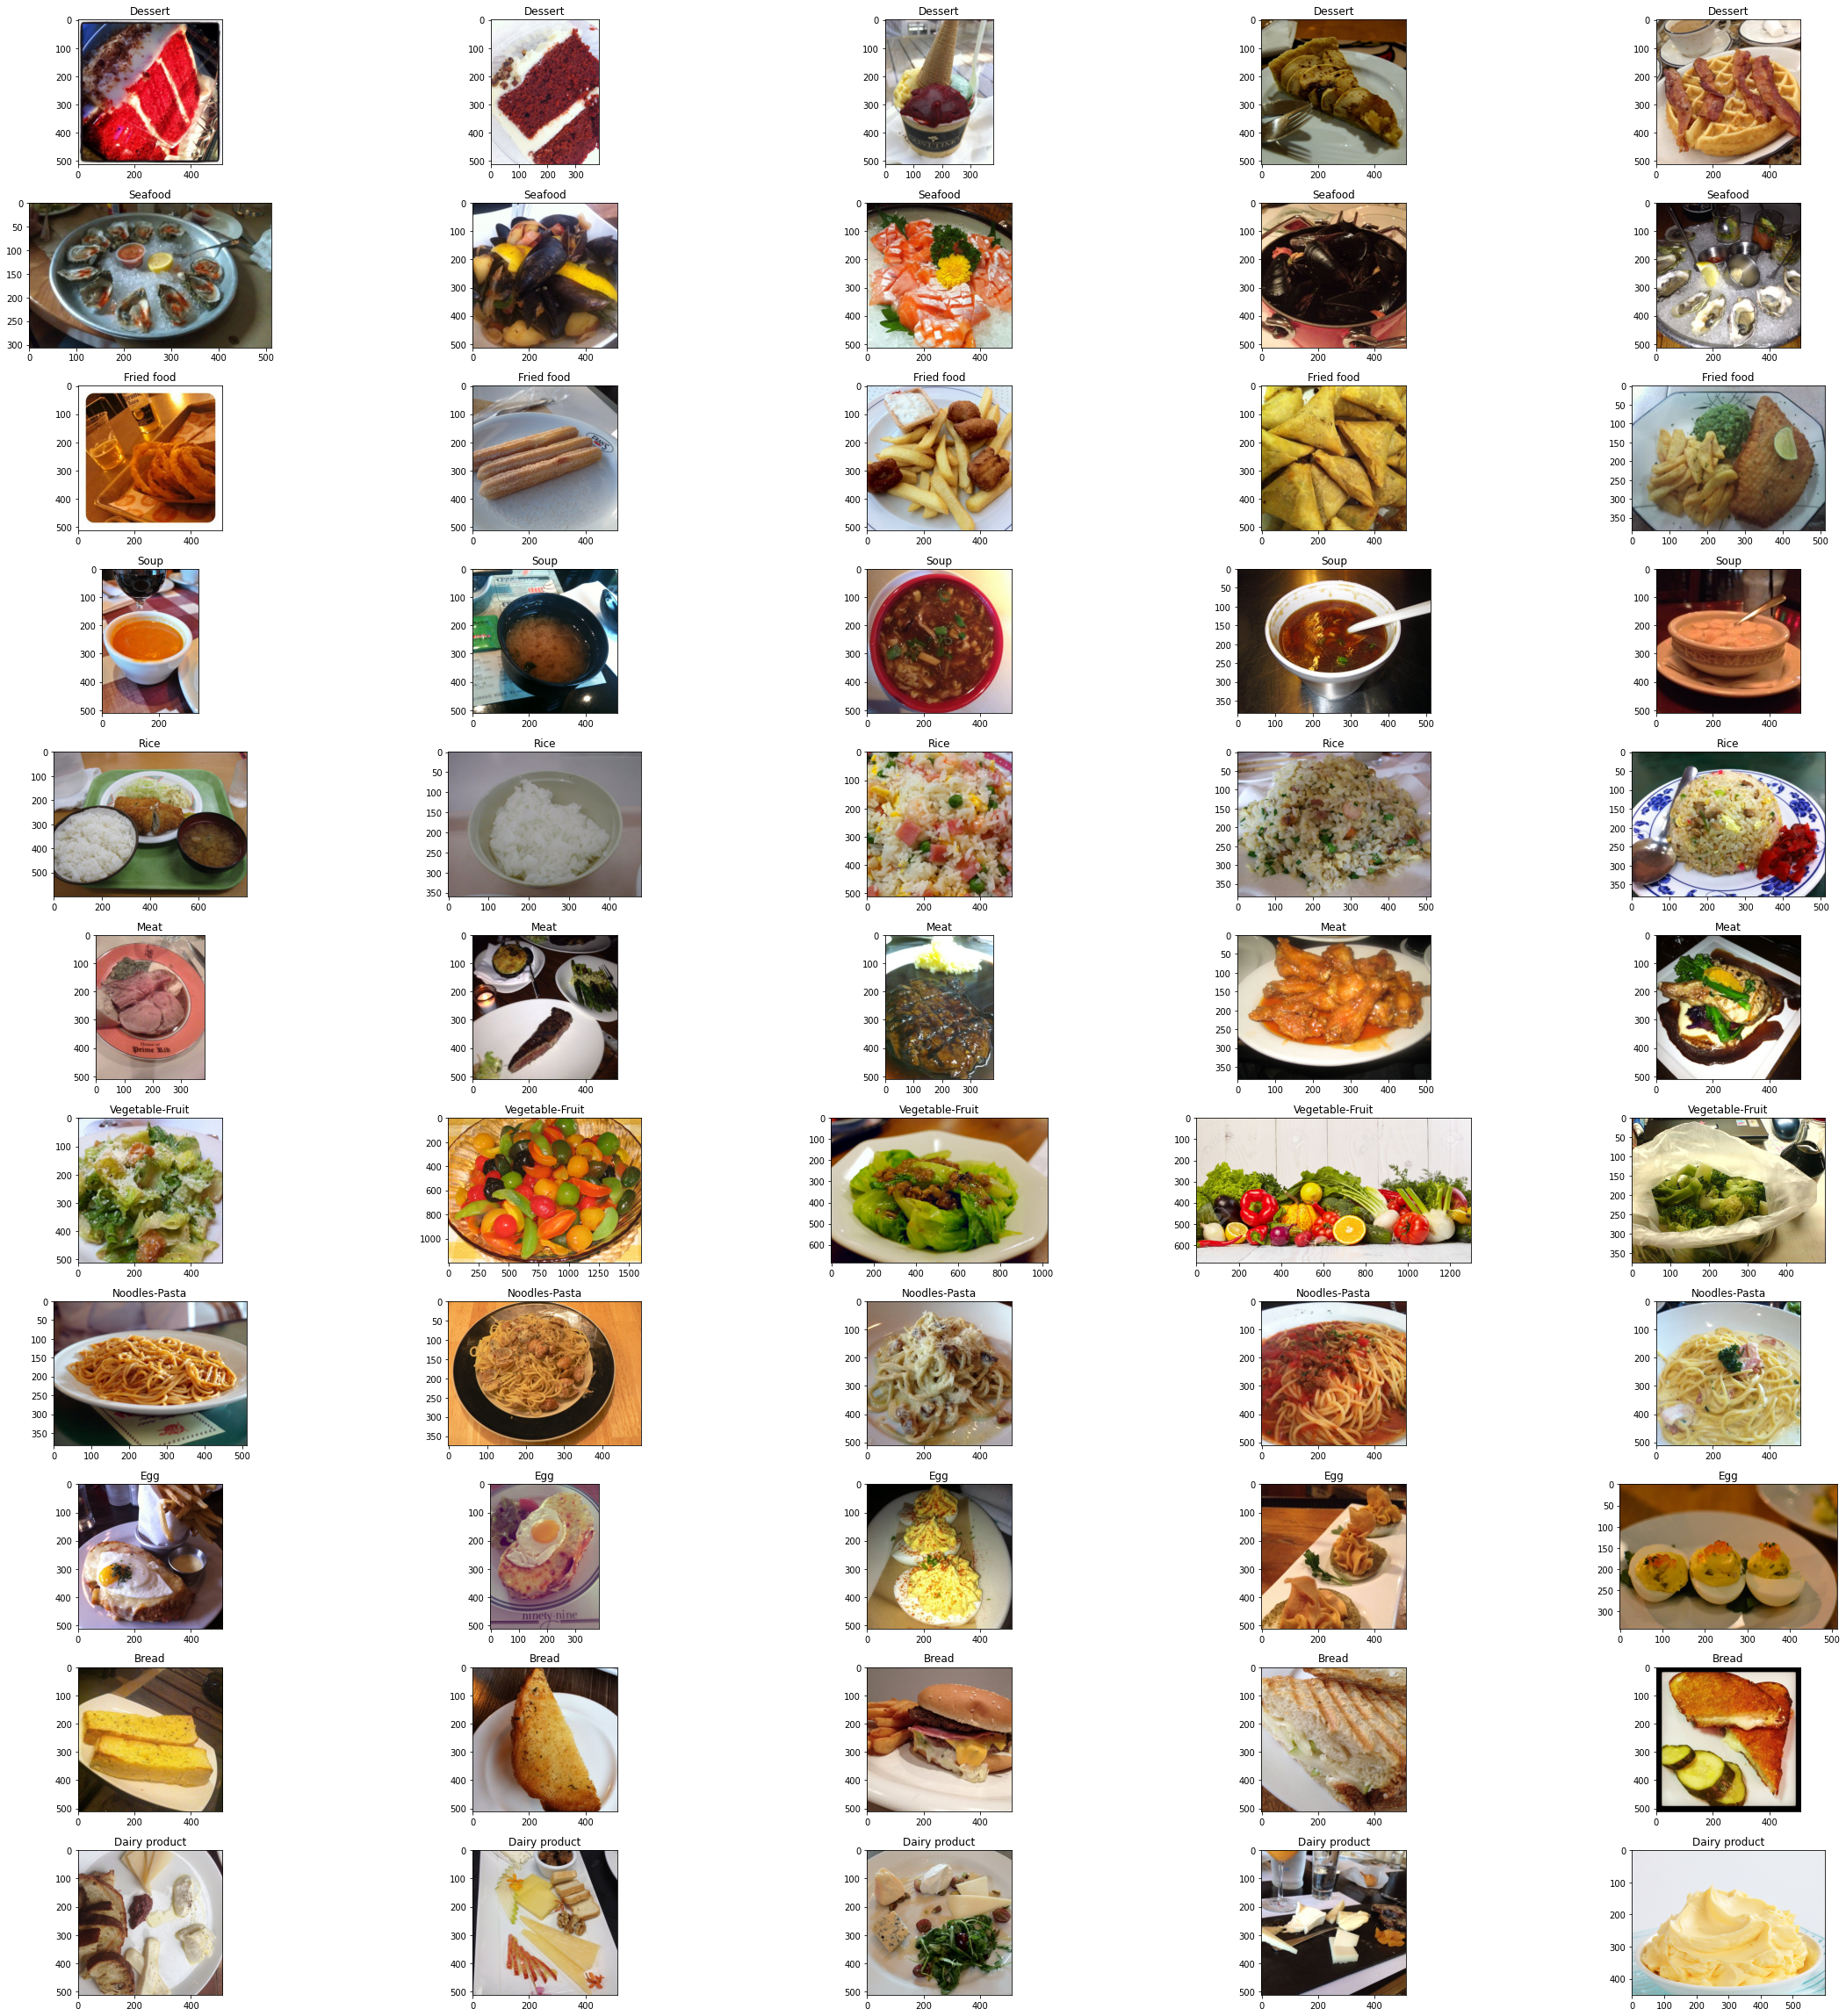

In [ ]:
fig, axs = plt.subplots(11, 5, figsize = (32, 32))
count = 0
for i in os.listdir('./training'):
  # get the list of images in the particualr class
  train_class = os.listdir(os.path.join('training',i))
  #plot 5 images per class
  for j in range(5):
    img = os.path.join('training',i,train_class[j])
    
    img = PIL.Image.open(img)
    axs[count][j].title.set_text(i)
    axs[count][j].imshow(img)  
  count += 1

fig.tight_layout()

In [ ]:
#check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []
for i in os.listdir('./training'):
  train_class = os.listdir(os.path.join('training',i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i,len(train_class)))

Number of images in Dessert = 1500 

Number of images in Seafood = 855 

Number of images in Fried food = 848 

Number of images in Soup = 1500 

Number of images in Rice = 280 

Number of images in Meat = 1325 

Number of images in Vegetable-Fruit = 709 

Number of images in Noodles-Pasta = 440 

Number of images in Egg = 986 

Number of images in Bread = 994 

Number of images in Dairy product = 429 



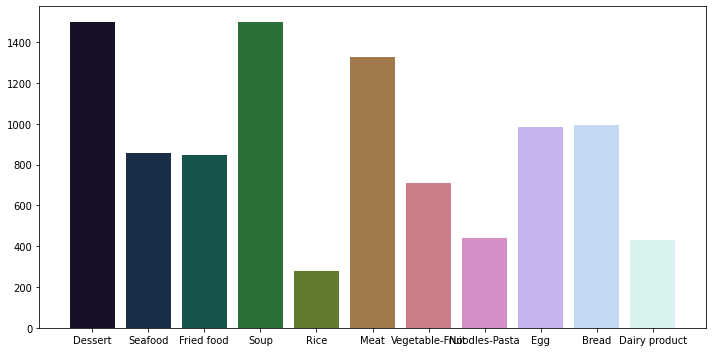

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.bar(Class_name, No_images_per_class,color = sns.color_palette("cubehelix",len(Class_name)))
fig.tight_layout()

## Performing Data Augmentation

In [ ]:
# For Training Datat
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# For Testing Data
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
#Creating datagenerator for training, validation and test dataset.

train_generator = train_datagen.flow_from_directory('training', target_size=(256, 256), batch_size = 32,
                                                    class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory('validation', target_size = (256, 256), batch_size = 32,
                                                        class_mode='categorical')

test_generator = test_datagen.flow_from_directory('evaluation', target_size = (256, 256), batch_size = 32,
                                                  class_mode = 'categorical')

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


## Making A Model

In [ ]:
basemodel = InceptionResNetV2(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

# Do Not Want To Train These Weights
basemodel.trainable = False

219062272/219055592 [==============================] - 1s 0us/step


In [ ]:
#Add classifiction head to the model
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D(name = 'global_average_pool')(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu", name = 'dense_1')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu", name = 'dense_2')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(11, activation = 'softmax', name = 'dense_3')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

## Compiling And Running The Model

In [ ]:
#compile the model
model.compile(loss = 'categorical_crossentropy', optimizer= SGD(lr=.01, momentum=.9) , metrics= ["accuracy"])

In [ ]:
#using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

#save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 32, epochs = 100, 
                    validation_data= validation_generator, validation_steps= validation_generator.n // 32, 
                    callbacks=[checkpointer, earlystopping])

***
***THE MODEL WAS GOING TO TAKE 35MINS PER EPOCH (ON GPU), THAT IS WHY IT WAS NOT RUN***
***

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

## Evaluating The Model

### Loading The Model and Evaluating The Performance

In [ ]:
model.load_weights("weights_fine.hdf5")

In [ ]:
#Evaluate the performance of the model
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 32, verbose =1)
print('Accuracy Test : {}'.format(evaluate[1]))

### Visualizing The Results

In [ ]:
#assigning label names to the corresponding indexes
labels = {0: 'Bread', 1: 'Dairy product', 2: 'Dessert', 3:'Egg', 4: 'Fried food', 
          5:'Meat', 6:'Noodles-Pasta', 7:'Rice', 8:'Seafood', 9:'Soup', 10: 'Vegetable-Fruit'}

In [ ]:
#loading images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2

prediction = []
original = []
image = []
count = 0
for i in os.listdir('./evaluation'):
  for item in os.listdir(os.path.join('./evaluation',i)):

    img= PIL.Image.open(os.path.join('./evaluation',i,item))
    img = img.resize((256,256))
    image.append(img)
    img = np.asarray(img, dtype= np.float32)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)

    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(labels[predict])
    original.append(i)

In [ ]:
#Getting the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

In [ ]:
#visualizing the results
import random
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

### Classification Report and Confusion Matrix

In [ ]:
#classiication report
print(classification_report(np.asarray(original), np.asarray(prediction)))

In [ ]:
#plotting confusion matrix

plt.figure(figsize=(20,20))
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

# TASK #10: VISUALIZING ACTIVATION MAPS THROUGH GRAD-CAM:

In [ ]:
def grad_cam(img):

  #Covert the image to array of type float32
  img = np.asarray(img, dtype= np.float32)

  #Reshape the image from (256,256,3) to (1,256,256,3)
  img = img.reshape(-1,256,256,3)
  img_scaled = img / 255

  #Name of the layers we added to the base_model, you can find this in the model summaty
  #Every-time you run the model, check the summary, as the name would change or to avoid it 
  #you can add name to each layer
  classification_layers = ["global_average_pool","dense_1","dense_2","dense_3"]

  #Last convolutional layer in the base mdel, this woun't change as name has been already assigned to it.
  final_conv = model.get_layer("conv_7b")

  #Create a model with original model input as input and the last conv_layer as the output
  final_conv_model = keras.Model(model.inputs, final_conv.output)

  #Then,we create the input for classification layer, which is the output of last conv layer
  #In our case, output produced by the conv layer is of the shape (1,6,6,1536) 
  #Since, the classification input needs the features as input, we ignore the batch dimension

  classification_input = keras.Input(shape=final_conv.output.shape[1:])

  # We iterate through the classification layers, to get the final layer and then, append 
  #the layer as the output layer to the classification model.
  temp = classification_input
  for layer in classification_layers:
      temp = model.get_layer(layer)(temp)
  classification_model = keras.Model(classification_input, temp)


  #We use gradient tape to monitor the 'final_conv_output' to retrive the gradients
  #corresponding to the predicted class
  with tf.GradientTape() as tape:
      # Pass the image through the base model and get the feature map 
      final_conv_output = final_conv_model(img_scaled)

      #Assign gradient tape to monitor the conv_output
      tape.watch(final_conv_output)
      
      #Pass the feature map through the classification model and use argmax to get the 
      #index of the predicted class and then use the index to get the value produced by final
      #layer for that class
      prediction = classification_model(final_conv_output)
      predicted_class = tf.argmax(prediction[0])
      predicted_class_value = prediction[:, predicted_class]

  #Get the gradient corresponding to the predicted class based on feature map.
  #which is of shape (1,6,6,1536)
  gradient = tape.gradient(predicted_class_value, final_conv_output)

  #Since we need the filter values (1536), we reduce the other dimensions, 
  #hich would result in a shape of (1536,)
  gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

  #We then convert the feature map produced by last conv layer(1,6,6,1536) to (6,6,1536)

  final_conv_output = final_conv_output.numpy()[0]

  gradient_channels = gradient_channels.numpy()

  #We multiply the filters in the feature map produced by final conv layer by the 
  #filter values that are used to get the predicted class. By doing this we inrease the
  #value of areas that helped in making the prediction and lower the vlaue of areas, that 
  #did not contribute towards the final prediction
  for i in range(gradient_channels.shape[-1]):
      final_conv_output[:, :, i] *= gradient_channels[i]

  #We take the mean accross the channels to get the feature map
  heatmap = np.mean(final_conv_output, axis=-1)

  #Normalizing the heat map between 0 and 1, to visualize it
  heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

  # Rescaling and converting the type to int
  heatmap = np.uint8(255 * heatmap_normalized )

  # Create the colormap
  color_map = plt.cm.get_cmap('jet')

  # get only the rb features from the heatmap
  color_map = color_map(np.arange(256))[:, :3]
  heatmap = color_map[heatmap]

  #convert the array to image, resize the image and then convert to array
  heatmap = keras.preprocessing.image.array_to_img(heatmap)
  heatmap = heatmap.resize((256, 256))
  heatmap = np.asarray(heatmap, dtype = np.float32)

  # Add the heatmap o top of the original image
  final_img = heatmap * 0.8 + img[0]
  final_img = keras.preprocessing.image.array_to_img(final_img)

  return final_img, heatmap_normalized



In [ ]:
#Visualize the images in the dataset
import random
fig, axs = plt.subplots(11,3, figsize=(32,32))
count = 0
for _ in range(11):
  i = random.randint(0,len(image))
  gradcam, heatmap = grad_cam(image[i])
  axs[count][0].title.set_text("Original -" + original[i])
  axs[count][0].imshow(image[i])
  axs[count][1].title.set_text("Prediction -" + prediction[i]) 
  axs[count][1].matshow(heatmap)
  axs[count][2].title.set_text("Heatmap") 
  axs[count][2].imshow(gradcam)  
  count += 1

fig.tight_layout()